In [15]:
%matplotlib inline 
import numpy as np
import scipy.io.wavfile as wav
import os
from scipy.signal import spectrogram
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold,StratifiedKFold,LeaveOneOut,LeavePOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.grid_search import GridSearchCV
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.spatial import distance
from scipy import signal
from sklearn.metrics.pairwise import pairwise_distances

import pdb

### Cut music into short pieces and save to foler for future use

In [3]:
def cutMusic(open_path,save_path,genres,win=10):
    #for each genres
    save_format="{0}{1}/{2}"
    for u in genres:
        #read raw signal in the folder
        file_list=os.listdir(open_path+u)
        #create new folder in save path if doesn't exist
        if not os.path.exists(save_path+u):
            os.makedirs(save_path+u)
        for v in file_list:
            #read audio
            fs,data=wav.read(open_path+u+'/'+v)
            #cut in to 'win' seconds
            wav.write(save_format.format(save_path,u,v),fs,data[:win*fs]) 

### read audio signal and create labels

In [4]:
def readMusic(open_path,genres,win=10):
    #data
    X=np.array([],dtype=np.float)
    X_unnormalized=np.array([],dtype=np.float)
    #label
    Y=np.array([],dtype=np.int).reshape(1,0)
    genres_list=genres
    #for each genre
    for i,u in enumerate(genres_list):
        file_list=os.listdir(open_path+u)
        #create label for each genres
        y=np.ones((1,len(file_list)),dtype=np.int)*(i+1)
        Y=np.hstack((Y,y))
        for v in file_list:
            fs,data=wav.read(open_path+u+'/'+v)            
            data=data.astype(np.int32)
            #add noises to test robustness
            #data=data+np.random.normal(0,1,data.shape[0])*max(abs(data))/100
            unnormalized_data=data
            #normalize signal to -1 1
            data=data/float(max(abs(data)))
            #cut signal to win size
            data=data[:win*fs].reshape(1,win*fs)
            X=np.vstack((X,data)) if X.size else data
            unnormalized_data=unnormalized_data[:win*fs].reshape(1,win*fs)
            X_unnormalized=np.vstack((X_unnormalized,unnormalized_data)) if X_unnormalized.size else unnormalized_data
    return fs,X,Y[0],X_unnormalized

### Create filter banks for Mel-freqency cepstral coefficients
nfft: fft length, fs: sampling rate, f:frequency components, filter_num: filter number

In [5]:
def filterBank(nfft,fs,f,filter_num=40):
    #convert to mel freqency
    mel_f=lambda f: 2595*np.log10(1+f/700.0)
    #inverse mel
    inv_mel=lambda m: 700*(10**(m/2595.0)-1)
    #low and high frequency range. conver to mel freq
    mel_fl=mel_f(300)
    mel_fh=mel_f(10000)
    #linearly spaced 
    mel_f=np.linspace(mel_fl,mel_fh,num=filter_num+2)
    inv_f=inv_mel(mel_f)
    inv_f=f[np.floor((nfft+1)*inv_f/fs).astype(int)-1]
    #build filter
    mel_h=np.zeros((len(f),filter_num))
    for i in xrange(filter_num):
        a=f>=inv_f[i]
        b=f<inv_f[i+1]
        mel_h[a&b,i]=(f[a&b]-inv_f[i])/(inv_f[i+1]-inv_f[i])
        a=f>=inv_f[i+1]
        b=f<inv_f[i+2]
        mel_h[a&b,i]=(inv_f[i+2]-f[a&b])/(inv_f[i+2]-inv_f[i+1])

    #fig,ax=plt.subplots(figsize=(8,3))
    #plt.plot(f,mel_h)
    #plt.xlim([0,11000])
    #plt.title('filter bank')
    #plt.xlabel('f(Hz)')
    return mel_h

### MFCC features
pxx: power spectral,  mel_h: filter bank

In [6]:
def MFCCS(pxx,mel_h):
    filter_num=mel_h.shape[1]
    #apply filter bank to power spectral
    mfccs=np.dot(mel_h.T,pxx);
    #log ,than dct
    mfccs=dct(np.log10(mfccs+1e-20),axis=0)

    #sum and variance along time slices
    sum_mfccs=np.sum(mfccs,axis=1)
    var_mfccs=np.var(mfccs,axis=1)
    mfccs=np.hstack((sum_mfccs[1:13],var_mfccs[1:13]))

    return mfccs
    

### zero crossing rate
x: blocked signal

In [7]:
def zeroCrossing(x):
    #how many successive points cross zero point
    zc=map(lambda x: np.mean(abs(np.diff(np.sign(x))/2)),x)
    return np.array(zc)
    

### short time energy

x：blocked signal

In [8]:
def shortEnergy(x):
    #power of signal amplitude
    se=map(lambda x: np.mean(x**2),x)
    return np.array(se)
    

### main part of feature extraction
four types of features:
Mel-frequency cepstral coefficients, zero crossing rate, short time energy, IQR
X:normalized signal,X:unomalized signal, fs:sampling rate, win: window size of spectrogram, overlap: overlap of sliding window, blocknum: how many segments in zero crossing rate and short time energy, nfft: fft length

In [9]:
def featureExtraction(X,X_unnormalized,fs,win=882,overlap=220,blocknum=10,nfft=1024):
    
    #spectrogram
    f,t,pxx=spectrogram(X,fs,window='boxcar',nperseg=win,noverlap=overlap,nfft=nfft,scaling='spectrum')
    #built filter bank of MFCC and calculate MFCC
    filters=filterBank(nfft,fs,f,filter_num=40)
    mfccs=MFCCS(pxx,filters)
    
    #split signal into blocks
    block_x=np.split(X,blocknum)
    #zero crossing rate
    zc=zeroCrossing(block_x)
    #short time energy
    se=shortEnergy(block_x)
    
    iqr=np.array(np.percentile(X_unnormalized,75)-np.percentile(X_unnormalized,25))
    
    feature=np.hstack((mfccs,zc,se,iqr))
    
    return feature

### functions to plot distance plot
features: calculated features  start:start position of features want to involved end:end position of features want to involved


In [10]:
def select_feature(features,start,end):
    return features[:,start:end+1]
def feature_plot(features,start,end):
    #select features
    f_new=select_feature(features,start,end)
    #normalize
    min_max_scaler = MinMaxScaler()
    f_new = min_max_scaler.fit_transform(f_new)
    #calculate pair-wise distance
    d=pairwise_distances(f_new)
    #plot
    d=d/np.max(d)
    d=d.astype('float32')
    plt.figure()
    plt.imshow(d,cmap='Greys_r')
    plt.show()

### main part of the program:
1.read in signal
2.calculate feature
3.classification

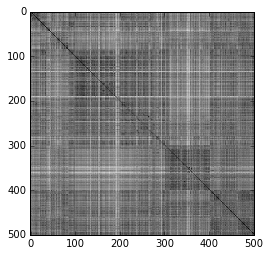

In [11]:
open_path="genres/"
save_path="10s/"
genres=['blues','classical','jazz','pop','rock']
cutMusic(open_path,save_path,genres,win=10)
fs,X,Y,X_unnormalized=readMusic(save_path,genres,win=10)

#feature extraction
features=np.array([],dtype=np.float)
for i in xrange(X.shape[0]):
    feature=featureExtraction(X[i],X_unnormalized[i],fs,win=882,overlap=220,blocknum=2,nfft=1024)
    features=np.vstack((features,feature)) if features.size else feature

feature_plot(features,start=0,end=29)

### grid search for knn to find best k. 
features:calculated features

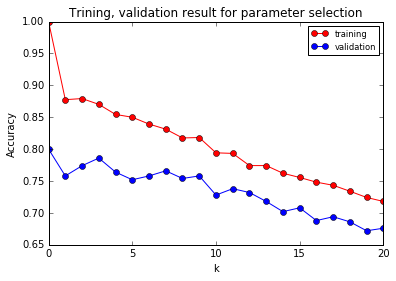

In [12]:
def grid_search_knn(features):
    #10 fold cross validation
    kf=StratifiedKFold(Y,n_folds=10,shuffle=True,random_state =42)
    #range of candidate k
    k=range(1,int(np.sqrt(features.shape[0])))

    result_test=np.zeros(len(k))
    result_train=np.zeros(len(k))
    for k1 in k:#for each k
        acc_train=0
        acc_test=0
        for train_index, vali_index in kf:#for each fold
            X_train, X_vali = features[train_index], features[vali_index]
            y_train, y_vali = Y[train_index], Y[vali_index]
            
            #normalize to 0 1
            min_max_scaler = MinMaxScaler()
            X_train_minmax = min_max_scaler.fit_transform(X_train)
            X_vali_minmax = min_max_scaler.transform(X_vali)
            
            #train and test classifiers
            clf=KNeighborsClassifier(n_neighbors=k1) 
            clf.fit(X_train_minmax, y_train)
            y_pred_train=clf.predict(X_train_minmax)
            y_pred_vali=clf.predict(X_vali_minmax)
            
            #accuracy
            acc_train+=accuracy_score(y_train,y_pred_train)
            acc_test+=accuracy_score(y_vali,y_pred_vali)
        #calculate average accuracy for cross-validation
        result_train[k1-1]=acc_train/10.0
        result_test[k1-1]=acc_test/10.0
    #plot 
    fig,ax=plt.subplots()
    plt.plot(result_train,'ro-',label='training')
    plt.plot(result_test,'bo-',label='validation')
    plt.ylabel('Accuracy')
    plt.title('Trining, validation result for parameter selection')
    plt.xlabel('k')
    ax.legend(loc='best', prop={'size':'small'})
grid_search_knn(features)

### training and testing process with leave-one-out process using KNN and 29 features

In [14]:
#leave-one-out
kf=LeaveOneOut(n=features.shape[0])
acc_knn=[]
con_knn=[]
y_predall_knn=[]
y_truth=[]

#for each fold
for train_index, test_index in kf:
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #normalize to 0 1
    min_max_scaler = MinMaxScaler()
    X_train_minmax = min_max_scaler.fit_transform(X_train)
    X_test_minmax = min_max_scaler.transform(X_test)

    #knn
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train_minmax, y_train)
    y_pred_knn=clf.predict(X_test_minmax)
    acc_knn.append(accuracy_score(y_test,y_pred_knn))
    con_knn.append(confusion_matrix(y_test, y_pred_knn))
    
    y_predall_knn.append(y_pred_knn[0])    
    y_truth.append(y_test[0])


print "confusion matrix:"
print confusion_matrix(y_truth, y_predall_knn)
print 'accuracy:',np.mean(acc_knn)


confusion matrix:
[[82  1  2  2 13]
 [ 1 91  3  1  4]
 [11  8 73  1  7]
 [ 4  1  3 85  7]
 [15  3  6  7 69]]
accuracy: 0.8


In [19]:
#k-fold cross validation
kf=StratifiedKFold(Y,n_folds=5,shuffle=True,random_state =42)
acc_knn=[]
con_knn=[]
y_predall_knn=[]
y_truth=[]

#for each fold
for train_index, test_index in kf:
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #normalize to 0 1
    min_max_scaler = MinMaxScaler()
    X_train_minmax = min_max_scaler.fit_transform(X_train)
    X_test_minmax = min_max_scaler.transform(X_test)

    #knn
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X_train_minmax, y_train)
    y_pred_knn=clf.predict(X_test_minmax)
    acc_knn.append(accuracy_score(y_test,y_pred_knn))
    con_knn.append(confusion_matrix(y_test, y_pred_knn))
    

print "confusion matrix:"
con_avg=np.zeros(con_knn[0].shape)
for c in con_knn:
    con_avg+=c
print con_avg
print 'accuracy:',np.mean(acc_knn)


confusion matrix:
[[ 80.   1.   3.   2.  14.]
 [  0.  89.   4.   2.   5.]
 [ 10.  13.  67.   2.   8.]
 [  3.   3.   1.  86.   7.]
 [ 14.   3.   4.   7.  72.]]
accuracy: 0.788


### plot IQR

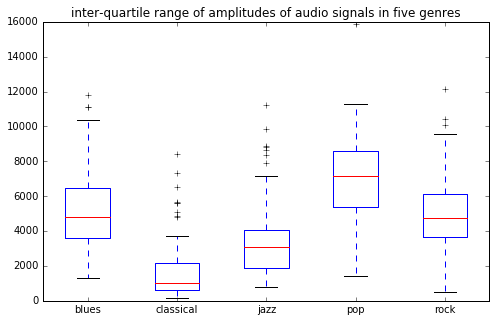

In [20]:
a=[]
x2=np.percentile(X_unnormalized,75,axis=1)-np.percentile(X_unnormalized,25,axis=1)
    
for i in xrange(5):    
    a.append(x2[i*100:(i+1)*100])
fig,ax=plt.subplots(figsize=(8,5))
ax.boxplot(a,labels=genres)
ax.set_title('inter-quartile range of amplitudes of audio signals in five genres')
